In [16]:
import sys
import logging
import pickle
import yaml
import matplotlib.cm as cm
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import time
import seaborn as sns
import pandas as pd
from configs import engram_dir

# Parameters

In [62]:
episodes = np.arange(100, 700, 100)

In [18]:
internal_dim = 10
exp_name = 'gridworld_discount0.9_eps1.0_dm_dim10_shuffobs'
network_yaml = 'dm'
models = ['mf0', 'g0_-2_entro-1', 'entro-1']

In [19]:
# internal_dim = 10
# generic_exp_name = 'iqn_shuffobs'
# network_yaml = 'iqn'
# models = ['mf1']

In [20]:
nnets_dir = f'{engram_dir}nnets/{exp_name}/'
pickle_dir = f'{engram_dir}pickles/{exp_name}/'
analysis_dir = f'{engram_dir}analysis/{exp_name}/'

# Helper functions

In [56]:
def manhattan_dist(loc1, loc2):
    xdist = np.abs(loc1[0]-loc2[0])
    ydist = np.abs(loc1[1]-loc2[1])
    return xdist + ydist

def make_input_cov_matrix(xys, gamma=0.5):
    n_samples = xys.shape[0]
    cov_matrix = np.zeros((n_samples, n_samples))
    np.fill_diagonal(cov_matrix, 1)
    for i in range(n_samples):
        for j in range(0, i):
            dist = manhattan_dist(xys[i], xys[j])
            cov = gamma**dist
            cov_matrix[i, j] = cov_matrix[j, i] = cov
    return cov_matrix

def get_kernel_alignment(K_A, K_B):
    numerator = np.trace(K_A @ K_B)
    denominator = np.sqrt(np.trace(K_A @ K_A) * np.trace(K_B @ K_B))
    alignment = numerator/denominator
    return alignment

# Load analysis

In [21]:
recalculate = True

In [22]:
if 'iqn' in generic_exp_name:
    pfile = 'pickles/kernel_alignment_iqn.p'
else:
    pfile = 'pickles/kernel_alignment.p'

In [84]:
if recalculate:
    # Load all dataframes
    dfs = []
    for episode in episodes:
        with open(f'{analysis_dir}representation_df_ep{episode}.p', 'rb') as f:
            repr_df = pickle.load(f)
        repr_df['episode'] = episode
        dfs.append(repr_df)
    dfs = pd.concat(dfs)
    results = {
        'kernel alignment': [],
        'model': [],
        'episode': []}

    # Make input covariance matrix
    xys = []
    for x in np.unique(dfs['x']):
        for y in np.unique(dfs['y']):
            xys.append([x,y])
    xys = np.array(xys)
    K_inputs = make_input_cov_matrix(xys, gamma=0.7)

    # Get kernel alignment for each model seed and episode
    for model in models:
        model_df = dfs[dfs['model']==model]
        iterations = np.unique(model_df['iteration'])
        for i in iterations:
            iter_df = model_df[model_df['iteration']==i]
            for episode in episodes:
                _df = iter_df[iter_df['episode']==episode]
                latents = []
                for xy in xys:
                    __df = _df[(_df['x']==xy[0])&(_df['y']==xy[1])]
                    if len(__df.index) != 1: continue
                    latents.append(np.array(__df.iloc[0]['latents']))
                latents = np.array(latents) # (samples, dim)
                latents -= latents.mean(0)[None,:]
                K_latents = latents @ latents.T
                val = get_kernel_alignment(K_latents, K_inputs)
                results['kernel alignment'].append(val)
                results['model'].append(model)
                results['episode'].append(episode)
#     with open(pfile, 'wb') as f:
#         pickle.dump(results, f)
else:
    with open(pfile, 'rb') as f:
        results = pickle.load(f)

# Main plot

In [85]:
df = pd.DataFrame(results)

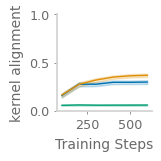

In [86]:
fig, ax = plt.subplots(figsize=(1.5, 1.5), constrained_layout=True)
sns.lineplot(y='kernel alignment', x='episode',
    hue_order=models,
    hue='model',
    linewidth=1, data=df, legend=None)
plt.ylim(0,1)
plt.xlabel('Training Steps')
#plt.ylabel('Inner Product')
#plt.savefig('1g.png', dpi=300, transparent=True)
plt.show()